In [4]:
import pandas as pd
import numpy as np
import json
import math
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)


In [5]:
VIDEO_CSV_PATH = "video_data.json"
CATEGORIES_JSON_PATH = "video_categories.json"
CHANNEL_JSON_PATH = "channel_data (1).json"


In [6]:
video_raw = pd.read_json(VIDEO_CSV_PATH, lines=True)
print("Video data shape:", video_raw.shape)
display(video_raw.head())

with open(CATEGORIES_JSON_PATH, "r", encoding="utf-8") as f:
    categories_raw = json.load(f)

print("Category JSON keys:", categories_raw.keys())
print("Number of category items:", len(categories_raw.get("items", [])))

cat_map = {
    int(item["id"]): item["snippet"]["title"]
    for item in categories_raw["items"]
}
with open(CHANNEL_JSON_PATH, "r", encoding="utf-8") as f:
    channel_list = json.load(f)

channel_df = pd.DataFrame(channel_list)
print("Channel data shape:", channel_df.shape)
display(channel_df.head())

Video data shape: (440772, 13)


,channel_id,channel_title,video_id,category_id,published_at,title,description,thumbnail,view_count,like_count,favorite_count,comment_count,tags
0,UCYIvQrhDDhRE8MzS7eRrPsQ,A3,3niQ1dJcqFg,1,2021-08-14 05:51:05+00:00,Los Angeles street art,Taking a look at Los Angeles graffiti and mura...,https://i.ytimg.com/vi/3niQ1dJcqFg/default.jpg,11.0,1.0,0,0.0,NaN
1,UCYIvQrhDDhRE8MzS7eRrPsQ,A3,51b-1WotLww,1,2021-08-06 04:17:37+00:00,Los Angeles street art # graffiti # bomber,Taking a look at Los Angeles street art \n@ gr...,https://i.ytimg.com/vi/51b-1WotLww/default.jpg,13.0,2.0,0,0.0,NaN
2,UCgOGQK5_1x6GDxvhnOQdqeA,CF,jd2B6rH--tg,1,2021-02-09 20:09:05+00:00,The infinite bicycle,A favorite scene from the movie In The Mouth o...,https://i.ytimg.com/vi/jd2B6rH--tg/default.jpg,15321.0,175.0,0,29.0,"In The Mouth of Madness,John Carpenter,Horror"
3,UCsEukrAd64fqA7FjwkmZ_Dw,GQ,TRGHIN2PGIA,1,2022-10-05 16:00:12+00:00,Christian Bale Breaks Down His Most Iconic Cha...,Christian Bale breaks down a few of his most i...,https://i.ytimg.com/vi/TRGHIN2PGIA/default.jpg,15569853.0,457300.0,0,18103.0,"american psycho,amsterdam,celebrity,christian ..."
4,UCF3qBBXKBFkT6ykYlEZh6Gw,A K,VqDRhf1UpvE,1,2012-03-14 20:21:25+00:00,Smart Card (2005),Smartcard is a story about a man who realizes ...,https://i.ytimg.com/vi/VqDRhf1UpvE/default.jpg,29366.0,293.0,0,29.0,"card,id,identity,technology,future,short film,..."


Category JSON keys: dict_keys(['kind', 'etag', 'items'])
Number of category items: 32
Channel data shape: (1561, 11)


,channel_id,channel_title,description,custom_url,created_at,thumbnail,country,view_count,subscriber_count,hidden_subscribers,video_count
0,UC6sfgGx5u8qCpWeqMxFWpjQ,Crypto Trade1,Cryptotrade1 is basically providing trading si...,@cryptotrade1,2017-11-14T07:12:04Z,https://yt3.ggpht.com/vR-Cl98vUxtqxKOOh9YwDC7_...,AE,32872,1140,false,376
1,UCwQp7Wc1NIKrW4UTOgOmVKg,The Meaning Of Islam,"Assalam Alaikum!\nI’m Ayesha, the creator of “...",@themeaningofislam,2011-10-26T09:33:39Z,https://yt3.ggpht.com/ytc/AGIKgqP8TvqgrQpOpLiT...,AE,88557098,503000,false,121
2,UCZ245tjtaxNCb0Y4i9H9AXQ,Fernando Romero Moreno,Por un Frente Nacional que defienda los valore...,@fernandoromeromoreno1519,2014-07-28T20:45:20Z,https://yt3.ggpht.com/ytc/AGIKgqPe8zceaOY-88SQ...,AR,15661,666,false,47
3,UCNDrlU4YJrjPwO0yB7SG-bg,Ojo de Halcón,None,@ojodehalcon,2017-09-11T03:18:17Z,https://yt3.ggpht.com/ytc/AGIKgqPj3rmRbMVZ_gmt...,AR,28714333,94400,false,3312
4,UCFHAPATvu8q49hy53VPv6SA,Red Internacional de Promotores ODS,Canal Oficial de videos de la Red Internaciona...,@redinternacionaldepromotor7015,2020-02-22T17:10:07.38079Z,https://yt3.ggpht.com/ytc/AGIKgqOnCTiIM6cdyLSV...,AR,103219,5940,false,139


In [7]:
video_df = video_raw.copy()
video_df["category_title"] = video_df["category_id"].map(cat_map)
video_df["published_at"] = pd.to_datetime(video_df["published_at"], errors="coerce")
video_df["published_year"] = video_df["published_at"].dt.year
for col in ["view_count", "like_count", "favorite_count", "comment_count"]:
    video_df[col] = pd.to_numeric(video_df[col], errors="coerce")
video_df["like_count"] = video_df["like_count"].fillna(0)
video_df["comment_count"] = video_df["comment_count"].fillna(0)
video_df["like_rate"] = video_df["like_count"] / video_df["view_count"]
video_df["comment_rate"] = video_df["comment_count"] / video_df["view_count"]

print("Cleaned data shape:", video_df.shape)
display(video_df.head())

Cleaned data shape: (440772, 17)


,channel_id,channel_title,video_id,category_id,published_at,title,description,thumbnail,view_count,like_count,favorite_count,comment_count,tags,category_title,published_year,like_rate,comment_rate
0,UCYIvQrhDDhRE8MzS7eRrPsQ,A3,3niQ1dJcqFg,1,2021-08-14 05:51:05+00:00,Los Angeles street art,Taking a look at Los Angeles graffiti and mura...,https://i.ytimg.com/vi/3niQ1dJcqFg/default.jpg,11.0,1.0,0,0.0,NaN,Film & Animation,2021,0.090909,0.000000
1,UCYIvQrhDDhRE8MzS7eRrPsQ,A3,51b-1WotLww,1,2021-08-06 04:17:37+00:00,Los Angeles street art # graffiti # bomber,Taking a look at Los Angeles street art \n@ gr...,https://i.ytimg.com/vi/51b-1WotLww/default.jpg,13.0,2.0,0,0.0,NaN,Film & Animation,2021,0.153846,0.000000
2,UCgOGQK5_1x6GDxvhnOQdqeA,CF,jd2B6rH--tg,1,2021-02-09 20:09:05+00:00,The infinite bicycle,A favorite scene from the movie In The Mouth o...,https://i.ytimg.com/vi/jd2B6rH--tg/default.jpg,15321.0,175.0,0,29.0,"In The Mouth of Madness,John Carpenter,Horror",Film & Animation,2021,0.011422,0.001893
3,UCsEukrAd64fqA7FjwkmZ_Dw,GQ,TRGHIN2PGIA,1,2022-10-05 16:00:12+00:00,Christian Bale Breaks Down His Most Iconic Cha...,Christian Bale breaks down a few of his most i...,https://i.ytimg.com/vi/TRGHIN2PGIA/default.jpg,15569853.0,457300.0,0,18103.0,"american psycho,amsterdam,celebrity,christian ...",Film & Animation,2022,0.029371,0.001163
4,UCF3qBBXKBFkT6ykYlEZh6Gw,A K,VqDRhf1UpvE,1,2012-03-14 20:21:25+00:00,Smart Card (2005),Smartcard is a story about a man who realizes ...,https://i.ytimg.com/vi/VqDRhf1UpvE/default.jpg,29366.0,293.0,0,29.0,"card,id,identity,technology,future,short film,...",Film & Animation,2012,0.009978,0.000988


In [8]:
print("=== Info ===")
video_df.info()

print("\n=== Summary statistics (views / likes / comments) ===")
display(video_df[["view_count", "like_count", "comment_count"]].describe())

print("\n=== Categories and counts ===")
display(video_df["category_title"].value_counts())

print("\n=== Engagement rates ===")
display(video_df[["like_rate", "comment_rate"]].describe())


=== Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440772 entries, 0 to 440771
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   channel_id      440772 non-null  object             
 1   channel_title   440754 non-null  object             
 2   video_id        440772 non-null  object             
 3   category_id     440772 non-null  int64              
 4   published_at    440772 non-null  datetime64[ns, UTC]
 5   title           440772 non-null  object             
 6   description     412826 non-null  object             
 7   thumbnail       440772 non-null  object             
 8   view_count      440266 non-null  float64            
 9   like_count      440772 non-null  float64            
 10  favorite_count  440772 non-null  int64              
 11  comment_count   440772 non-null  float64            
 12  tags            329136 non-null  object             
 13  c

,view_count,like_count,comment_count
count,4.402660e+05,4.407720e+05,4.407720e+05
mean,5.359834e+06,4.849428e+04,2.594902e+03
std,6.612952e+07,4.370986e+05,4.506597e+04
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.790000e+02,2.200000e+01,2.000000e+00
50%,2.444300e+04,5.540000e+02,4.800000e+01
75%,3.096828e+05,6.659000e+03,5.960000e+02
max,1.336200e+10,5.215314e+07,1.591971e+07



=== Categories and counts ===


,count
category_title,
News & Politics,89052
Music,84805
People & Blogs,79242
Entertainment,54724
Education,35187
Gaming,16079
Science & Technology,15767
Film & Animation,12690
Nonprofits & Activism,10950



=== Engagement rates ===


,like_rate,comment_rate
count,4.398420e+05,4.398180e+05
mean,inf,inf
std,NaN,NaN
min,0.000000e+00,0.000000e+00
25%,9.014837e-03,1.858042e-04
50%,2.229488e-02,1.451981e-03
75%,5.488020e-02,6.288676e-03
max,inf,inf


In [9]:
video_df.to_csv("video_data_clean.csv", index=False)
print("Saved cleaned data to video_data_clean.csv")


Saved cleaned data to video_data_clean.csv


In [10]:
df_ml = video_df[["view_count", "like_count", "comment_count", "category_title"]].copy()
df_ml = df_ml[df_ml["view_count"] > 0]

y = np.log1p(df_ml["view_count"].values)

X_numeric = df_ml[["like_count", "comment_count"]]
X_cat = pd.get_dummies(df_ml["category_title"], prefix="cat", drop_first=True)

X = pd.concat([X_numeric, X_cat], axis=1)

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)
X.head()


Feature matrix shape: (439816, 17)
Target vector shape: (439816,)


,like_count,comment_count,cat_Comedy,cat_Education,cat_Entertainment,cat_Film & Animation,cat_Gaming,cat_Howto & Style,cat_Music,cat_News & Politics,cat_Nonprofits & Activism,cat_People & Blogs,cat_Pets & Animals,cat_Science & Technology,cat_Sports,cat_Trailers,cat_Travel & Events
0,1.0,0.0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
1,2.0,0.0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
2,175.0,29.0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
3,457300.0,18103.0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
4,293.0,29.0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

rmse_train = mse_train ** 0.5
rmse_test = mse_test ** 0.5

print("Random Forest Regression Results (log(1 + views))")
print("------------------------------------------------")
print(f"Train R^2: {r2_train:.3f}")
print(f"Test  R^2: {r2_test:.3f}")
print(f"Train RMSE: {rmse_train:.3f}")
print(f"Test  RMSE: {rmse_test:.3f}")


Random Forest Regression Results (log(1 + views))
------------------------------------------------
Train R^2: 0.942
Test  R^2: 0.891
Train RMSE: 0.936
Test  RMSE: 1.275


Top 10 most important features:


,0
like_count,0.935005
comment_count,0.046342
cat_Music,0.006720
cat_People & Blogs,0.002052
cat_Gaming,0.001991
cat_News & Politics,0.001556
cat_Entertainment,0.001148
cat_Film & Animation,0.000977
cat_Education,0.000706
cat_Sports,0.000577


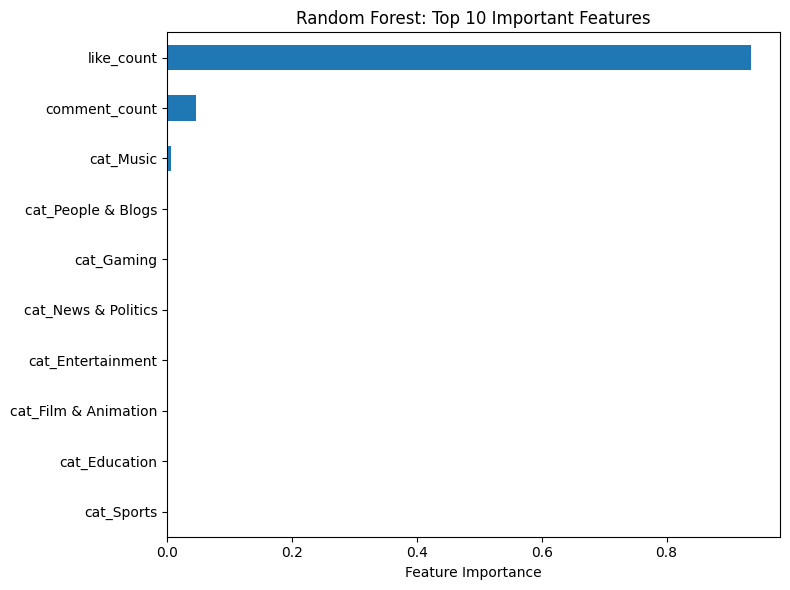

In [12]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=False)

print("Top 10 most important features:")
display(importances_sorted.head(10))

plt.figure(figsize=(8, 6))
importances_sorted.head(10).plot(kind="barh")
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Random Forest: Top 10 Important Features")
plt.tight_layout()
plt.show()


In [20]:
features = video_df[["like_rate", "comment_rate"]].copy()
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features.fillna(0, inplace=True)

video_df["like_rate"].replace([np.inf, -np.inf], np.nan, inplace=True)
video_df["comment_rate"].replace([np.inf, -np.inf], np.nan, inplace=True)
video_df["like_rate"].fillna(0, inplace=True)
video_df["comment_rate"].fillna(0, inplace=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=0, n_init=10)
video_df["engagement_cluster"] = kmeans.fit_predict(X_scaled)

print("Cluster counts:")
print(video_df["engagement_cluster"].value_counts())

print("\nCluster-wise averages:")
cluster_stats = video_df.groupby("engagement_cluster")[
    ["view_count", "like_rate", "comment_rate"]
].mean()
display(cluster_stats)

/tmp/ipython-input-2077331313.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  video_df["like_rate"].replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipython-input-2077331313.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value,

Cluster counts:
engagement_cluster
0    438199
2      2555
1        18
Name: count, dtype: int64

Cluster-wise averages:


,view_count,like_rate,comment_rate
engagement_cluster,,,
0,5.391271e+06,0.041280,0.006079
1,1.017778e+02,19.005213,0.603666
2,1.210282e+04,0.243320,0.299579


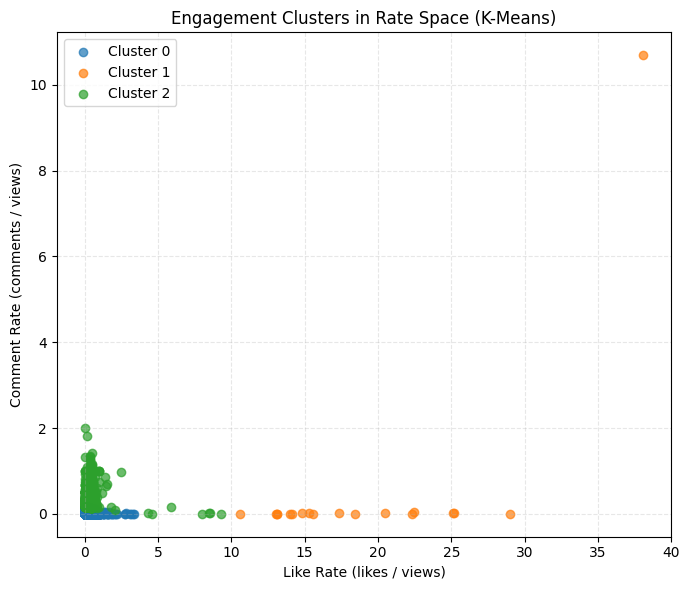

In [15]:
plt.figure(figsize=(7, 6))
for c in sorted(video_df["engagement_cluster"].unique()):
    subset = video_df[video_df["engagement_cluster"] == c]
    plt.scatter(
        subset["like_rate"],
        subset["comment_rate"],
        alpha=0.7,
        label=f"Cluster {c}"
    )

plt.xlabel("Like Rate (likes / views)")
plt.ylabel("Comment Rate (comments / views)")
plt.title("Engagement Clusters in Rate Space (K-Means)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


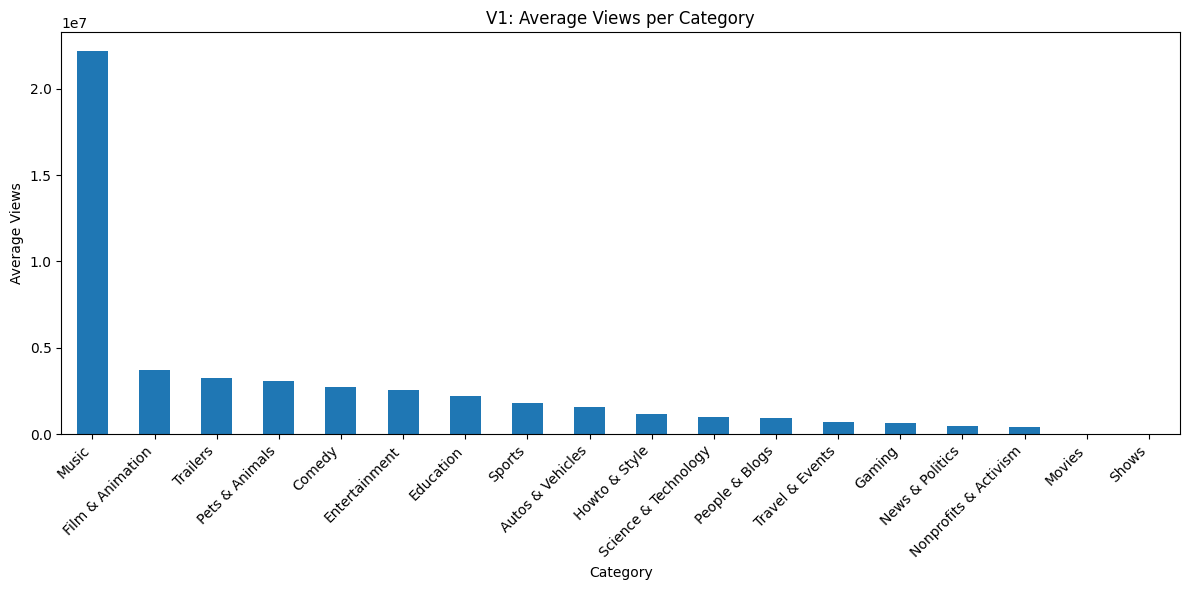

In [16]:
category_views = (
    video_df
    .groupby("category_title")["view_count"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(12, 6))
category_views.plot(kind="bar")
plt.xlabel("Category")
plt.ylabel("Average Views")
plt.title("V1: Average Views per Category")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


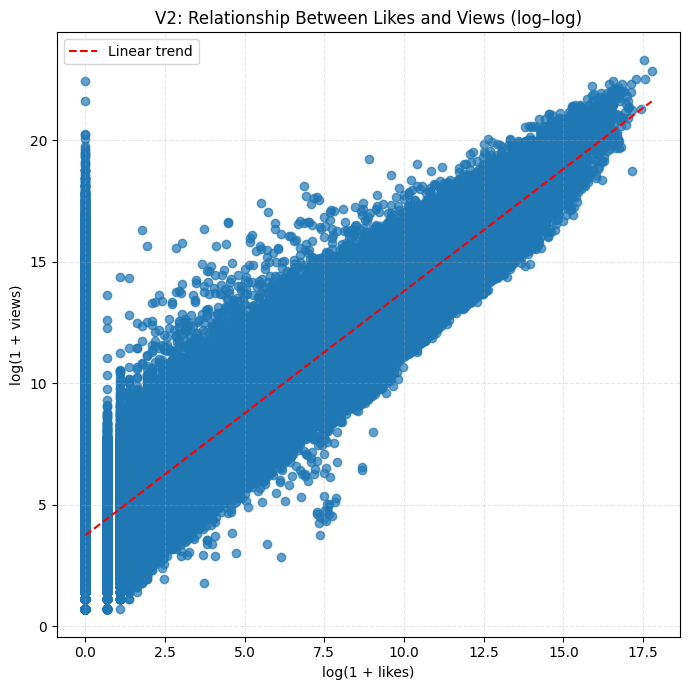

In [17]:
df_plot = df_ml.copy()
df_plot["log_likes"] = np.log1p(df_plot["like_count"])
df_plot["log_views"] = np.log1p(df_plot["view_count"])

plt.figure(figsize=(7, 7))
plt.scatter(df_plot["log_likes"], df_plot["log_views"], alpha=0.7)

# Simple linear fit for visualization (not the RF model)
coef = np.polyfit(df_plot["log_likes"], df_plot["log_views"], deg=1)
x_line = np.linspace(df_plot["log_likes"].min(), df_plot["log_likes"].max(), 100)
y_line = coef[0] * x_line + coef[1]
plt.plot(x_line, y_line, 'r--', label="Linear trend")

plt.xlabel("log(1 + likes)")
plt.ylabel("log(1 + views)")
plt.title("V2: Relationship Between Likes and Views (log–log)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

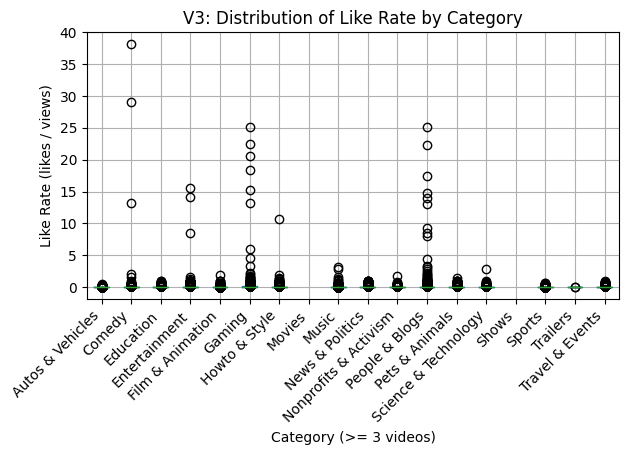

In [18]:
category_counts = video_df["category_title"].value_counts()
valid_cats = category_counts[category_counts >= 3].index

video_box = video_df[video_df["category_title"].isin(valid_cats)].copy()

plt.figure(figsize=(12, 6))
video_box.boxplot(column="like_rate", by="category_title", vert=True)
plt.title("V3: Distribution of Like Rate by Category")
plt.suptitle("")
plt.xlabel("Category (>= 3 videos)")
plt.ylabel("Like Rate (likes / views)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


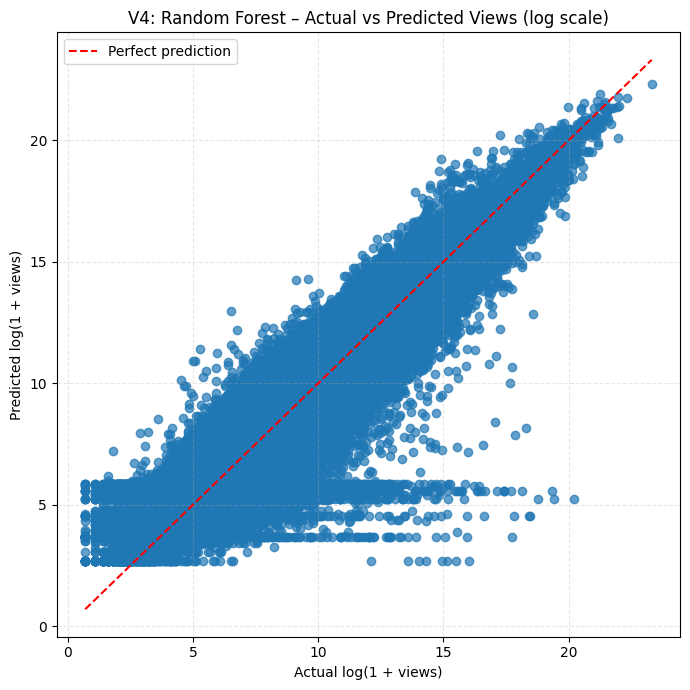

In [19]:
plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_test_pred, alpha=0.7)

min_val = min(y_test.min(), y_test_pred.min())
max_val = max(y_test.max(), y_test_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Perfect prediction")

plt.xlabel("Actual log(1 + views)")
plt.ylabel("Predicted log(1 + views)")
plt.title("V4: Random Forest – Actual vs Predicted Views (log scale)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()
